In [267]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                             f1_score, roc_auc_score, roc_curve, auc, make_scorer)
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [268]:
# =============================================================================
# STEP 1: LOAD LABELED DATA (FROM 6_label_data_5.ipynb)
# =============================================================================

print("="*70)
print("STEP 1: LOADING LABELED SONGS")
print("="*70)

# Load aggregated songs with labels
songs_labeled = pd.read_csv('songs_aggregated_labeled.csv', sep=';')

# Convert date columns
songs_labeled['first_appearance'] = pd.to_datetime(songs_labeled['first_appearance'])
songs_labeled['last_appearance'] = pd.to_datetime(songs_labeled['last_appearance'])

print(f"\n✓ Loaded labeled songs:")
print(f"  Total songs: {len(songs_labeled):,}")
print(f"  Training:    {songs_labeled['is_train'].sum():,}")
print(f"  Test:        {(~songs_labeled['is_train']).sum():,}")

print(f"\n✓ Columns:")
print(f"  {songs_labeled.columns.tolist()}")

print(f"\n✓ Label distribution:")
print(songs_labeled['popularity_label'].value_counts())

print(f"\n✓ Sample data:")
print(songs_labeled.head())

STEP 1: LOADING LABELED SONGS

✓ Loaded labeled songs:
  Total songs: 9,161
  Training:    7,572
  Test:        1,589

✓ Columns:
  ['id', 'best_rank', 'avg_rank', 'total_weeks_charted', 'first_appearance', 'last_appearance', 'Title', 'Artist', 'popularity_label', 'peak_score', 'longevity_score', 'popularity_score', 'is_train']

✓ Label distribution:
popularity_label
Not Popular    6378
Popular        2783
Name: count, dtype: int64

✓ Sample data:
                       id  best_rank    avg_rank  total_weeks_charted  \
0  000xQL6tZNLJzIrtIgxqSl         40  101.500000                  118   
1  003VDDA7J3Xb2ZFlNx7nIZ        108  138.000000                    2   
2  003eoIwxETJujVWmNFMoZy         91  136.500000                   14   
3  003vvx7Niy0yvhvHt4a68B         73  173.794872                  273   
4  00B7TZ0Xawar6NZ00JFomN         61  109.285714                   14   

  first_appearance last_appearance                                 Title  \
0       2017-03-24      2017-09-1

In [269]:
# =============================================================================
# STEP 2: LOAD AND MERGE AUDIO FEATURES
# =============================================================================

print("\n" + "="*70)
print("STEP 2: LOADING AND MERGING AUDIO FEATURES")
print("="*70)

# Load raw chart data to get audio features
df_charts = pd.read_csv("final_cleaned_data.csv", sep=';')
df_charts['Date'] = pd.to_datetime(df_charts['Date'])

print(f"\n✓ Loaded chart data: {len(df_charts):,} rows")

# Get unique song features (one row per song)
audio_features = df_charts.groupby('id').first()[['Danceability', 'Energy', 'Loudness_norm', 
                                                    'Speechiness', 'Acousticness', 
                                                    'Instrumentalness',  'Valence'
                                                    ]].reset_index()

print(f"\n✓ Extracted audio features: {len(audio_features):,} songs")
print(f"  Features: {audio_features.columns.tolist()}")

# Merge with labeled data
df_merged = songs_labeled.merge(audio_features, on='id', how='left')

print(f"\n✓ Merged dataset:")
print(f"  Shape: {df_merged.shape}")
print(f"  Missing values:")
missing = df_merged[['Danceability', 'Energy', 'Loudness_norm', 'Speechiness', 
                     'Acousticness', 'Instrumentalness', 'Valence']].isnull().sum()
                     
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("  None!")

print(f"\n✓ Sample merged data:")
print(df_merged.head())


STEP 2: LOADING AND MERGING AUDIO FEATURES

✓ Loaded chart data: 467,061 rows

✓ Extracted audio features: 9,161 songs
  Features: ['id', 'Danceability', 'Energy', 'Loudness_norm', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Valence']

✓ Merged dataset:
  Shape: (9161, 20)
  Missing values:
  None!

✓ Sample merged data:
                       id  best_rank    avg_rank  total_weeks_charted  \
0  000xQL6tZNLJzIrtIgxqSl         40  101.500000                  118   
1  003VDDA7J3Xb2ZFlNx7nIZ        108  138.000000                    2   
2  003eoIwxETJujVWmNFMoZy         91  136.500000                   14   
3  003vvx7Niy0yvhvHt4a68B         73  173.794872                  273   
4  00B7TZ0Xawar6NZ00JFomN         61  109.285714                   14   

  first_appearance last_appearance                                 Title  \
0       2017-03-24      2017-09-12  Still Got Time (feat. PARTYNEXTDOOR)   
1       2020-02-07      2020-02-08                               YELL OH   
2

In [270]:
# =============================================================================
# STEP 3: CALCULATE ARTIST FEATURES (FROM TRAINING DATA ONLY!)
# =============================================================================

print("\n" + "="*70)
print("STEP 3: CALCULATING ARTIST FEATURES (NO LEAKAGE)")
print("="*70)

# Split chart data by year (same as labeling step)
df_charts['Year'] = df_charts['Date'].dt.year
train_years = [2017, 2018, 2019, 2020, 2021]
test_years = [2022, 2023]

df_charts_train = df_charts[df_charts['Year'].isin(train_years)].copy()
df_charts_test = df_charts[df_charts['Year'].isin(test_years)].copy()

print(f"\n✓ Chart data split:")
print(f"  Training rows: {len(df_charts_train):,}")
print(f"  Test rows:     {len(df_charts_test):,}")

# Calculate artist features from TRAINING period only
print(f"\n📊 Calculating artist features from 2017-2021 data...")

artist_stats_train = df_charts_train.groupby('Artist (Ind.)').agg({
    'id': 'nunique',           # Number of unique songs
    'Rank': 'min',              # Best rank achieved
    'Date': 'nunique'           # Total appearances
}).reset_index()

artist_stats_train.columns = ['Artist', 'artist_song_count', 'artist_best_rank', 'artist_total_appearances']

# Calculate average rank (from all appearances)
artist_avg_rank = df_charts_train.groupby('Artist (Ind.)')['Rank'].mean().reset_index()
artist_avg_rank.columns = ['Artist', 'artist_avg_rank']

artist_stats_train = artist_stats_train.merge(artist_avg_rank, on='Artist')

print(f"\n✓ Artist features calculated:")
print(f"  Unique artists: {len(artist_stats_train):,}")
print(f"  Features: {artist_stats_train.columns.tolist()}")

# Show top artists
print(f"\n📋 Top 5 artists by song count:")
print(artist_stats_train.nlargest(5, 'artist_song_count')[['Artist', 'artist_song_count', 
                                                             'artist_best_rank', 'artist_avg_rank']])

# Merge artist features with our dataset
df_merged = df_merged.merge(artist_stats_train, on='Artist', how='left')

# Fill missing artist features (new artists in test set)
print(f"\n⚠️  Handling new artists (not in training data):")
new_artists = df_merged['artist_song_count'].isnull().sum()
print(f"  Songs with new artists: {new_artists:,}")

if new_artists > 0:
    # Fill with default values (median or safe defaults)
    df_merged['artist_song_count'].fillna(1, inplace=True)
    df_merged['artist_best_rank'].fillna(200, inplace=True)
    df_merged['artist_total_appearances'].fillna(1, inplace=True)
    df_merged['artist_avg_rank'].fillna(200, inplace=True)
    print(f"  ✓ Filled with default values")

print(f"\n✓ Dataset with artist features:")
print(f"  Shape: {df_merged.shape}")
print(df_merged.head())


STEP 3: CALCULATING ARTIST FEATURES (NO LEAKAGE)

✓ Chart data split:
  Training rows: 364,377
  Test rows:     102,684

📊 Calculating artist features from 2017-2021 data...

✓ Artist features calculated:
  Unique artists: 1,249
  Features: ['Artist', 'artist_song_count', 'artist_best_rank', 'artist_total_appearances', 'artist_avg_rank']

📋 Top 5 artists by song count:
            Artist  artist_song_count  artist_best_rank  artist_avg_rank
1076  Taylor Swift                174                 1        93.420591
307          Drake                138                 1        92.456124
96             BTS                100                 1        85.186964
382         Future                 99                 3       103.366083
544     Juice WRLD                 98                 2        98.867250

⚠️  Handling new artists (not in training data):
  Songs with new artists: 413
  ✓ Filled with default values

✓ Dataset with artist features:
  Shape: (9161, 24)
                       id

In [271]:
# Check artist features in test set
test_mask = df_merged['is_train'] == False
test_artists = df_merged[test_mask][['Artist', 'artist_song_count', 'artist_best_rank', 'artist_total_appearances', 'artist_avg_rank']]

# 1. Show new artists in test set (should have default values)
new_artist_rows = test_artists[
    (test_artists['artist_song_count'] == 1) &
    (test_artists['artist_best_rank'] == 200) &
    (test_artists['artist_total_appearances'] == 1) &
    (test_artists['artist_avg_rank'] == 200)
]
print(f"\nTest set songs with new artists (should be default values): {len(new_artist_rows)}")
print(new_artist_rows.head())

# 2. Show test set artists with non-default features (should all be from 2017-2021)
existing_artist_rows = test_artists[
    ~(
        (test_artists['artist_song_count'] == 1) &
        (test_artists['artist_best_rank'] == 200) &
        (test_artists['artist_total_appearances'] == 1) &
        (test_artists['artist_avg_rank'] == 200)
    )
]
print(f"\nTest set songs with artist features from training period: {len(existing_artist_rows)}")
print(existing_artist_rows.head())


Test set songs with new artists (should be default values): 413
              Artist  artist_song_count  artist_best_rank  \
7576  Dxrk ãƒ€ãƒ¼ã‚¯                1.0             200.0   
7600      La Pantera                1.0             200.0   
7604  Vishal-Shekhar                1.0             200.0   
7611         Quevedo                1.0             200.0   
7614           Rkomi                1.0             200.0   

      artist_total_appearances  artist_avg_rank  
7576                       1.0            200.0  
7600                       1.0            200.0  
7604                       1.0            200.0  
7611                       1.0            200.0  
7614                       1.0            200.0  

Test set songs with artist features from training period: 1176
            Artist  artist_song_count  artist_best_rank  \
7572   Miley Cyrus               32.0               5.0   
7573        j-hope                2.0              92.0   
7574  Brent Faiyaz         

In [272]:
# =============================================================================
# STEP 4: ADD TEMPORAL FEATURES
# =============================================================================

print("\n" + "="*70)
print("STEP 4: ADDING TEMPORAL FEATURES")
print("="*70)

# Extract temporal features from first_appearance date
df_merged['release_year'] = df_merged['first_appearance'].dt.year
df_merged['release_month'] = df_merged['first_appearance'].dt.month
df_merged['release_quarter'] = df_merged['first_appearance'].dt.quarter
df_merged['release_day_of_week'] = df_merged['first_appearance'].dt.dayofweek

# Chart lifespan (days between first and last appearance)
df_merged['chart_lifespan_days'] = (df_merged['last_appearance'] - df_merged['first_appearance']).dt.days

print(f"\n✓ Temporal features added:")
print(f"  - release_year")
print(f"  - release_month")
print(f"  - release_quarter")
print(f"  - release_day_of_week")
print(f"  - chart_lifespan_days")

print(f"\n📊 Temporal feature stats:")
print(df_merged[['release_year', 'release_month', 'release_quarter', 
                 'chart_lifespan_days']].describe())


STEP 4: ADDING TEMPORAL FEATURES

✓ Temporal features added:
  - release_year
  - release_month
  - release_quarter
  - release_day_of_week
  - chart_lifespan_days

📊 Temporal feature stats:
       release_year  release_month  release_quarter  chart_lifespan_days
count   9161.000000    9161.000000      9161.000000          9161.000000
mean    2019.544373       6.417531         2.475603            79.029145
std        1.801328       3.507384         1.131853           203.547522
min     2017.000000       1.000000         1.000000             0.000000
25%     2018.000000       3.000000         1.000000             1.000000
50%     2020.000000       6.000000         2.000000             8.000000
75%     2021.000000      10.000000         4.000000            62.000000
max     2023.000000      12.000000         4.000000          1825.000000


In [273]:
# =============================================================================
# STEP 5: PREPARE FEATURES FOR MODELING
# =============================================================================

print("\n" + "="*70)
print("STEP 5: PREPARING FEATURES FOR MODELING")
print("="*70)

# Define feature columns
audio_features_cols = ['Danceability', 'Energy', 'Loudness_norm', 'Speechiness', 
                       'Acousticness', 'Instrumentalness', 'Valence']
                       

#artist_features_cols = [ 
#                        'artist_song_count', 'artist_best_rank', 
#                        'artist_total_appearances', 'artist_avg_rank']

artist_features_cols = [ 
                        'artist_song_count', 
                        'artist_total_appearances']

temporal_features_cols = ['release_month', 'release_quarter', 
                          'release_day_of_week', 'chart_lifespan_days']

# all_features = audio_features_cols + artist_features_cols + temporal_features_cols
all_features = artist_features_cols + temporal_features_cols 
print(f"\n✓ Feature groups:")
print(f"  Audio features:    {len(audio_features_cols)}")
print(f"  Artist features:   {len(artist_features_cols)}")
print(f"  Temporal features: {len(temporal_features_cols)}")
print(f"  Total features:    {len(all_features)}")

# Check for missing values
print(f"\n🔍 Checking for missing values:")
missing = df_merged[all_features].isnull().sum()
if missing.sum() > 0:
    print("  ⚠️  Missing values found:")
    print(missing[missing > 0])
else:
    print("  ✅ No missing values!")

# Prepare X and y
X = df_merged[all_features].copy()
y = (df_merged['popularity_label'] == 'Popular').astype(int)  # Binary: 1=Popular, 0=Not Popular

print(f"\n✓ Feature matrix prepared:")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")
print(f"  y distribution: {y.value_counts().to_dict()}")


STEP 5: PREPARING FEATURES FOR MODELING

✓ Feature groups:
  Audio features:    7
  Artist features:   2
  Temporal features: 4
  Total features:    6

🔍 Checking for missing values:
  ✅ No missing values!

✓ Feature matrix prepared:
  X shape: (9161, 6)
  y shape: (9161,)
  y distribution: {0: 6378, 1: 2783}


In [274]:
# =============================================================================
# STEP 6: TRAIN/TEST SPLIT (USING is_train FLAG)
# =============================================================================

print("\n" + "="*70)
print("STEP 6: TRAIN/TEST SPLIT (TEMPORAL SPLIT)")
print("="*70)

# Split using the is_train flag from labeling step
train_mask = df_merged['is_train'] == True
test_mask = df_merged['is_train'] == False

X_train = X[train_mask].copy()
X_test = X[test_mask].copy()
y_train = y[train_mask].copy()
y_test = y[test_mask].copy()

print(f"\n✓ Train/test split:")
print(f"  Training set:   {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Test set:       {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

print(f"\n✓ Training label distribution:")
print(f"  Popular:     {y_train.sum():,} ({y_train.sum()/len(y_train)*100:.1f}%)")
print(f"  Not Popular: {(1-y_train).sum():,} ({(1-y_train).sum()/len(y_train)*100:.1f}%)")

print(f"\n✓ Test label distribution:")
print(f"  Popular:     {y_test.sum():,} ({y_test.sum()/len(y_test)*100:.1f}%)")
print(f"  Not Popular: {(1-y_test).sum():,} ({(1-y_test).sum()/len(y_test)*100:.1f}%)")

# Verify temporal separation
train_years_actual = df_merged[train_mask]['release_year'].unique()
test_years_actual = df_merged[test_mask]['release_year'].unique()

print(f"\n✓ Temporal integrity:")
print(f"  Training years: {sorted(train_years_actual)}")
print(f"  Test years:     {sorted(test_years_actual)}")


STEP 6: TRAIN/TEST SPLIT (TEMPORAL SPLIT)

✓ Train/test split:
  Training set:   7,572 samples (82.7%)
  Test set:       1,589 samples (17.3%)

✓ Training label distribution:
  Popular:     2,275 (30.0%)
  Not Popular: 5,297 (70.0%)

✓ Test label distribution:
  Popular:     508 (32.0%)
  Not Popular: 1,081 (68.0%)

✓ Temporal integrity:
  Training years: [2017, 2018, 2019, 2020, 2021]
  Test years:     [2022, 2023]


In [275]:
# =============================================================================
# STEP 7: SCALE FEATURES
# =============================================================================

print("\n" + "="*70)
print("STEP 7: SCALING FEATURES")
print("="*70)

# Fit scaler on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Features scaled using StandardScaler")
print(f"  Scaler fit on: Training data only (no leakage)")
print(f"  X_train_scaled shape: {X_train_scaled.shape}")
print(f"  X_test_scaled shape:  {X_test_scaled.shape}")

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(f"\n📊 Sample scaled features:")
print(X_train_scaled.head())


STEP 7: SCALING FEATURES

✓ Features scaled using StandardScaler
  Scaler fit on: Training data only (no leakage)
  X_train_scaled shape: (7572, 6)
  X_test_scaled shape:  (1589, 6)

📊 Sample scaled features:
   artist_song_count  artist_total_appearances  release_month  \
0          -0.280705                  0.122005      -1.030665   
1           0.949472                 -0.544711      -1.317047   
2          -0.663427                 -0.622731      -0.171519   
3          -0.718101                 -0.065952       0.401245   
4          -0.226031                  0.973132      -0.744283   

   release_quarter  release_day_of_week  chart_lifespan_days  
0        -1.367473             0.197458             0.387999  
1        -1.367473             0.197458            -0.387576  
2        -0.476916             0.197458            -0.333150  
3         0.413641             0.925735             1.889259  
4        -0.476916             0.197458            -0.333150  


In [276]:
# =============================================================================
# STEP 8: TRAIN BASELINE MODELS
# =============================================================================

print("\n" + "="*70)
print("STEP 8: TRAINING BASELINE MODELS")
print("="*70)

# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'SVM': SVC(random_state=42, probability=True),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

results = []

for model_name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training: {model_name}")
    print(f"{'='*50}")
    
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # Evaluate
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    
    # ROC AUC (if probability available)
    try:
        y_pred_proba_train = model.predict_proba(X_train_scaled)[:, 1]
        train_roc_auc = roc_auc_score(y_train, y_pred_proba_train)
    except:
        train_roc_auc = None
    try:
        y_pred_proba_test = model.predict_proba(X_test_scaled)[:, 1]
        test_roc_auc = roc_auc_score(y_test, y_pred_proba_test)
    except:
        test_roc_auc = None
  
    print(f"\n📊 Results:")
    print(f"  Training Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy:     {test_acc:.4f}")
    print(f"  Training F1:       {train_f1:.4f}")
    print(f"  Test F1:           {test_f1:.4f}")
    if train_roc_auc is not None:
        print(f"  Train ROC AUC:     {train_roc_auc:.4f}")
    if test_roc_auc is not None:
        print(f"  Test ROC AUC:      {test_roc_auc:.4f}")
    
    # Store results
    results.append({
        'Model': model_name,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Train F1': train_f1,
        'Test F1': test_f1,
        'Train ROC AUC': train_roc_auc,
        'Test ROC AUC': test_roc_auc
    })
    
    # Classification report
    print(f"\n📋 Test Classification Report:")
    print(classification_report(y_test, y_pred_test, target_names=['Not Popular', 'Popular']))

# Summary table
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


STEP 8: TRAINING BASELINE MODELS

Training: Logistic Regression

📊 Results:
  Training Accuracy: 0.7647
  Test Accuracy:     0.7143
  Training F1:       0.4712
  Test F1:           0.2557
  Train ROC AUC:     0.8055
  Test ROC AUC:      0.7469

📋 Test Classification Report:
              precision    recall  f1-score   support

 Not Popular       0.71      0.98      0.82      1081
     Popular       0.76      0.15      0.26       508

    accuracy                           0.71      1589
   macro avg       0.74      0.57      0.54      1589
weighted avg       0.73      0.71      0.64      1589


Training: Random Forest

📊 Results:
  Training Accuracy: 0.9978
  Test Accuracy:     0.8276
  Training F1:       0.9963
  Test F1:           0.6699
  Train ROC AUC:     0.9999
  Test ROC AUC:      0.9492

📋 Test Classification Report:
              precision    recall  f1-score   support

 Not Popular       0.82      0.96      0.88      1081
     Popular       0.86      0.55      0.67       50


STEP 9: VISUALIZING RESULTS


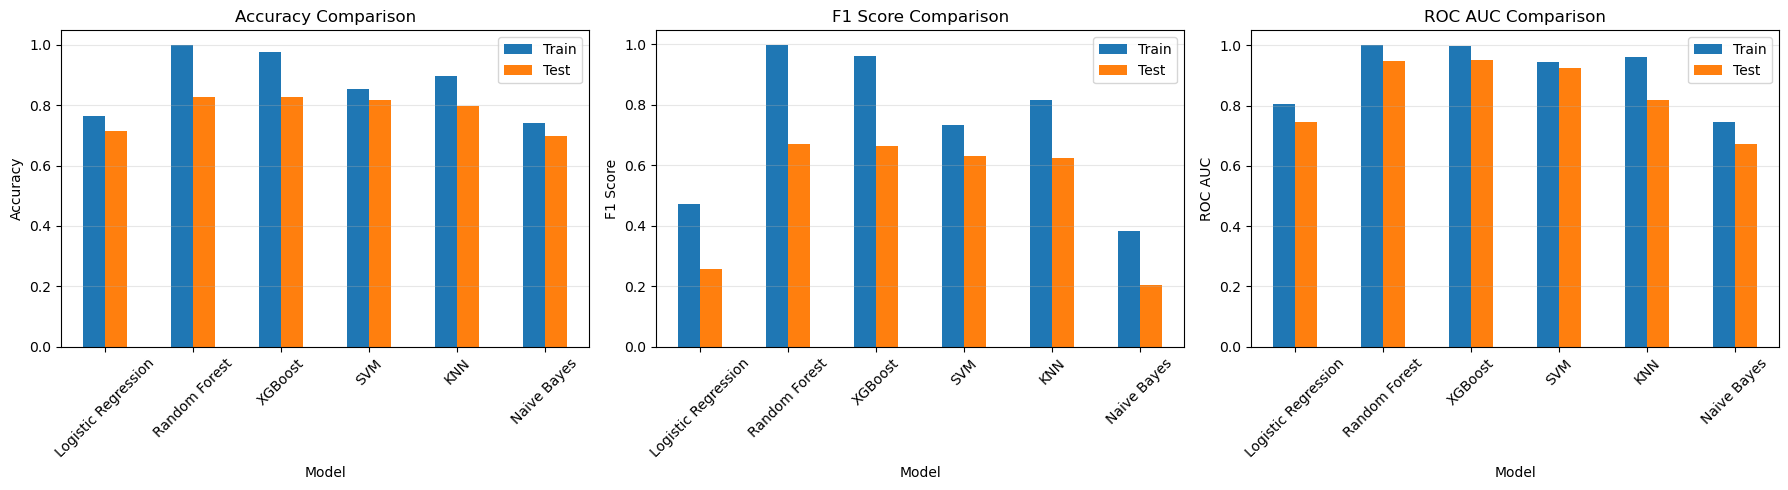


BEST MODEL CONFUSION MATRIX (TEST SET)
Best model: XGBoost


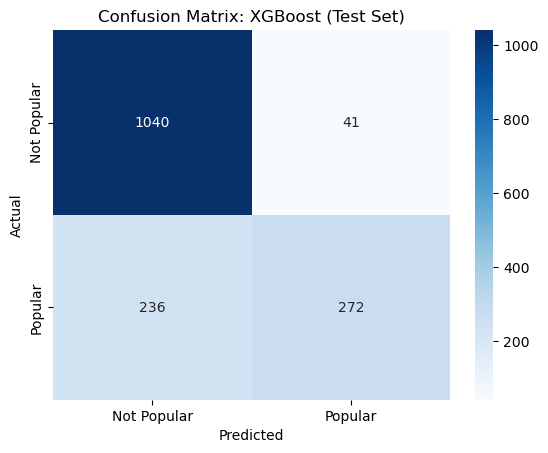

F1 score for 'Popular' songs (Test set, best model): 0.6626

Classification Report:
              precision    recall  f1-score   support

 Not Popular       0.82      0.96      0.88      1081
     Popular       0.87      0.54      0.66       508

    accuracy                           0.83      1589
   macro avg       0.84      0.75      0.77      1589
weighted avg       0.83      0.83      0.81      1589



In [277]:
# =============================================================================
# STEP 9: VISUALIZE RESULTS
# =============================================================================

print("\n" + "="*70)
print("STEP 9: VISUALIZING RESULTS")
print("="*70)

# Plot model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy comparison
results_df[['Model', 'Train Accuracy', 'Test Accuracy']].set_index('Model').plot(
    kind='bar', ax=axes[0], rot=45
)
axes[0].set_title('Accuracy Comparison')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Test'])
axes[0].grid(axis='y', alpha=0.3)

# F1 Score comparison
results_df[['Model', 'Train F1', 'Test F1']].set_index('Model').plot(
    kind='bar', ax=axes[1], rot=45
)
axes[1].set_title('F1 Score Comparison')
axes[1].set_ylabel('F1 Score')
axes[1].legend(['Train', 'Test'])
axes[1].grid(axis='y', alpha=0.3)

# ROC AUC comparison (show both train and test if available)
results_df_roc = results_df[results_df['Test ROC AUC'].notna() & results_df['Train ROC AUC'].notna()]
if not results_df_roc.empty:
    results_df_roc[['Model', 'Train ROC AUC', 'Test ROC AUC']].set_index('Model').plot(
        kind='bar', ax=axes[2], rot=45
    )
    axes[2].legend(['Train', 'Test'])
else:
    results_df_roc = results_df[results_df['Test ROC AUC'].notna()]
    results_df_roc[['Model', 'Test ROC AUC']].set_index('Model').plot(
        kind='bar', ax=axes[2], rot=45, legend=False
    )
axes[2].set_title('ROC AUC Comparison')
axes[2].set_ylabel('ROC AUC')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Confusion matrix for best model on test set
print("\n" + "="*70)
print("BEST MODEL CONFUSION MATRIX (TEST SET)")
print("="*70)

# Select best model by highest Test ROC AUC (fallback to Test Accuracy if all ROC AUC are None)
if results_df['Test ROC AUC'].notna().any():
    best_idx = results_df['Test ROC AUC'].idxmax()
else:
    best_idx = results_df['Test Accuracy'].idxmax()
best_model_name = results_df.loc[best_idx, 'Model']
print(f"Best model: {best_model_name}")

# Re-train best model and get predictions (to ensure y_pred_test is available)
best_model = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'SVM': SVC(random_state=42, probability=True),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}[best_model_name]
best_model.fit(X_train_scaled, y_train)
y_pred_test_best = best_model.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred_test_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Popular', 'Popular'], yticklabels=['Not Popular', 'Popular'])
plt.title(f'Confusion Matrix: {best_model_name} (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

f1_popular = f1_score(y_test, y_pred_test_best, pos_label=1)
print(f"F1 score for 'Popular' songs (Test set, best model): {f1_popular:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test_best,
                          target_names=['Not Popular', 'Popular']))
print("="*70)